In [37]:
import os
import pickle
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append(str(Path.cwd().parent))

In [38]:
# Directory containing pickle files
directory = Path("../results/classification/quantitative")

# Optionally filter for specific substrings
pkl_files = [f for f in directory.iterdir() if f.suffix == ".pkl"]

# Efficient loader
def load_file(file_path):
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            if isinstance(data, dict):
                return file_path.name, data
    except (EOFError, pickle.UnpicklingError) as e:
        print(f"Warning: Failed to load {file_path.name}: {e}")
    except Exception as e:
        print(f"Unexpected error with {file_path.name}: {e}")
    return None

# Load files using multithreading (I/O bound)
all_data = {}
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(load_file, f) for f in pkl_files]
    for future in as_completed(futures):
        result = future.result()
        if result:
            filename, data = result
            all_data[filename] = data

files = list(all_data.keys())


In [39]:
records = []

for file, dictionary in all_data.items():
    records.append(dictionary)

# Create the DataFrame
df = pd.DataFrame(records)


# df = df.dropna(
#     subset=[col for col in df.columns if col not in ['file', 'dataset_name', 'method_name', 'missing_type', 'pct', 'random_state']],
#     how='all'
# )


# df.drop(columns=['file'], inplace=True)
print(df.shape)



(8923, 15)


In [40]:
file

'dna_rfgap_k200_rs671156.pkl'

In [41]:
# Main methods: RF-ICE, Conformity (based on three proximity types), difference in probabilities (independent of proximities)

In [42]:
df.columns

Index(['prox_method', 'conformity_k', 'random_state', 'oob_score_',
       'diff_proba_auc', 'diff_proba_auc_test', 'conformity_auc',
       'conformity_auc_test', 'ice_auc', 'ice_auc_test', 'tree_conformity_auc',
       'tree_conformity_auc_test', 'name', 'n_features', 'n_samples'],
      dtype='object')

In [43]:
df_long = df.melt(
        id_vars=['name', 'random_state', 'prox_method', 'conformity_k'],
        value_vars=[
                'ice_auc', 'diff_proba_auc', 'conformity_auc',
                'ice_auc_test', 'diff_proba_auc_test', 'conformity_auc_test',
                'tree_conformity_auc', 'tree_conformity_auc_test'
        ],
        var_name='metric',
        value_name='auc'
)

In [44]:
df_long

,name,random_state,prox_method,conformity_k,metric,auc
0,mfeat-zernike,137338,rfgap,20,ice_auc,0.929630
1,qsar-biodeg,137338,oob,10,ice_auc,0.923954
2,mfeat-fourier,110269,oob,50,ice_auc,0.943474
3,pc4,54887,original,100,ice_auc,0.985011
4,mfeat-zernike,110269,oob,5,ice_auc,0.928315
...,...,...,...,...,...,...
71379,churn,131933,original,200,tree_conformity_auc_test,0.848689
71380,kr-vs-kp,54887,original,50,tree_conformity_auc_test,0.836209
71381,first-order-theorem-proving,137338,original,5,tree_conformity_auc_test,0.771495
71382,pc1,671156,original,20,tree_conformity_auc_test,0.466124


In [45]:
df_group = df_long.groupby(['prox_method', 'conformity_k', 'metric'])['auc'].agg(['mean', 'std']).reset_index()


In [46]:
df_group

,prox_method,conformity_k,metric,mean,std
0,oob,1,conformity_auc,0.933020,0.099374
1,oob,1,conformity_auc_test,0.934803,0.096275
2,oob,1,diff_proba_auc,0.924212,0.133391
3,oob,1,diff_proba_auc_test,0.927852,0.131991
4,oob,1,ice_auc,0.928631,0.110934
...,...,...,...,...,...
187,rfgap,500,diff_proba_auc_test,0.941055,0.082098
188,rfgap,500,ice_auc,0.931753,0.082595
189,rfgap,500,ice_auc_test,0.935867,0.075055
190,rfgap,500,tree_conformity_auc,0.785979,0.125879


In [47]:
df_group.metric.unique()

array(['conformity_auc', 'conformity_auc_test', 'diff_proba_auc',
       'diff_proba_auc_test', 'ice_auc', 'ice_auc_test',
       'tree_conformity_auc', 'tree_conformity_auc_test'], dtype=object)

In [48]:
df_group.loc[
    df_group['metric'].isin([
        'diff_proba_auc', 'diff_proba_auc_test',
        'tree_conformity_auc', 'tree_conformity_auc_test'
    ]),
    'prox_method'
] = 'NA'

In [49]:
df_group

,prox_method,conformity_k,metric,mean,std
0,oob,1,conformity_auc,0.933020,0.099374
1,oob,1,conformity_auc_test,0.934803,0.096275
2,NA,1,diff_proba_auc,0.924212,0.133391
3,NA,1,diff_proba_auc_test,0.927852,0.131991
4,oob,1,ice_auc,0.928631,0.110934
...,...,...,...,...,...
187,NA,500,diff_proba_auc_test,0.941055,0.082098
188,rfgap,500,ice_auc,0.931753,0.082595
189,rfgap,500,ice_auc_test,0.935867,0.075055
190,NA,500,tree_conformity_auc,0.785979,0.125879


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'conformity_auc'),
  Text(1, 0, 'conformity_auc_test'),
  Text(2, 0, 'diff_proba_auc'),
  Text(3, 0, 'diff_proba_auc_test'),
  Text(4, 0, 'ice_auc'),
  Text(5, 0, 'ice_auc_test'),
  Text(6, 0, 'tree_conformity_auc'),
  Text(7, 0, 'tree_conformity_auc_test')])

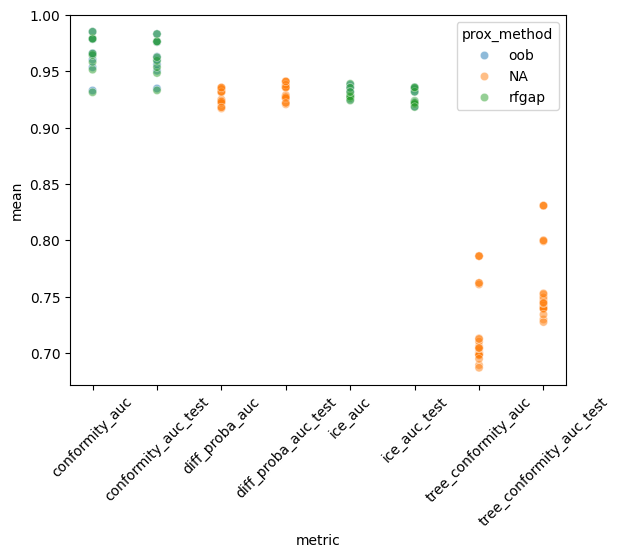

In [50]:
sns.scatterplot(data = df_group[df_group['prox_method'] != 'original'],
                x = 'metric', y = 'mean', hue = 'prox_method',
                alpha = 0.5)
plt.xticks(rotation=45)

/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper 

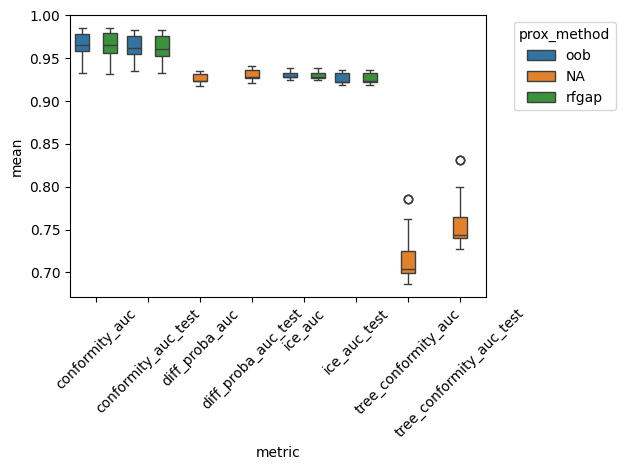

In [51]:
sns.boxplot(
    data=df_group[df_group['prox_method'] != 'original'],
    x='metric', y='mean', hue='prox_method'
)
plt.xticks(rotation=45)
plt.legend(title='prox_method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()